<a href="https://colab.research.google.com/github/pallavrajsahoo/Tweet-Emotion-Classification/blob/main/Tweet_Emotion_Classification_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

## Environment Setup

1. Installing Hugging Face's nlp package
2. Importing libraries

In [ ]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 212 kB 46.5 MB/s 


In [ ]:
%matplotlib inline

import re
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
import collections
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import wordnet
nltk.download("stopwords", quiet = True)
nltk.download("wordnet", quiet = True)
nltk.download("punkt", quiet = True)
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import word_tokenize
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.callbacks import Callback

## Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
data = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
data

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train = data['train']
val = data['validation']
test = data['test']

In [ ]:
train_tweet, train_label = train['text'], train['label']
val_tweet, val_label = val['text'], val['label']
test_tweet, test_label = test['text'], test['label']

In [ ]:
train_tweet[0], train_label[0]

('i didnt feel humiliated', 'sadness')

## Exploratory Data Analysis


1.   Initializing Hyperparameters
2.   Simple Data Visualization



In [ ]:
# Initialising Hyperparameters

NUM_WORDS = 10000
OOV_TOKEN = '<OOV>'
MAX_LEN = 50
TRUNCATING = 'post'
PADDING = 'post'

In [ ]:
length_of_words = [len(tweet.split(' ')) for tweet in train_tweet]

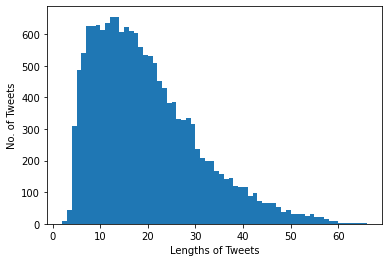

In [ ]:
plt.hist(length_of_words, bins=len(set(length_of_words)))
plt.xlabel('Lengths of Tweets')
plt.ylabel('No. of Tweets')
plt.show()

In [ ]:
all_labels = train_label + test_label + val_label

In [ ]:
len(all_labels)

20000

In [ ]:
classes = set(train_label)
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

In [ ]:
length_labels = dict(collections.Counter(train_label))
length_labels

{'anger': 2159,
 'fear': 1937,
 'joy': 5362,
 'love': 1304,
 'sadness': 4666,
 'surprise': 572}

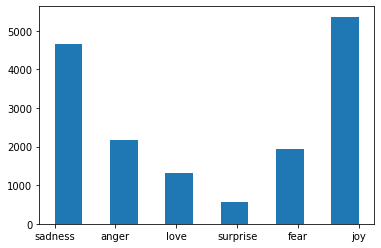

In [ ]:
plt.hist(train_label, bins = 11)
plt.show()

## Data Preprocessing


1.   Removing url links and punctuations from the tweets
2.   Removing stopwords
3.   Tokenizing and Lematizing the tokens
4.   Creating padded sequences
5.   Creating classes to index and index to classes dictionaries
6.   Vectorizing text labels




In [ ]:
# Removing stopwords, links and punctuations
# later lematizing the tokens

def preprocess(tweet):
  tweet = re.sub(r'[^\w\s]', '', tweet.lower())
  tweet = re.sub(r"\S*https?:\S*", "", tweet)
  tweet_tokens = word_tokenize(tweet)
  result=''
  for t in tweet_tokens:
        lemma = lemmatizer.lemmatize(t)
        if lemma not in set(stopwords.words('english')):
            result += lemma + ' '
  return result

In [ ]:
new_train_tweets = [preprocess(tweet) for tweet in train_tweet]
new_val_tweets = [preprocess(tweet) for tweet in val_tweet]

In [ ]:
new_train_tweets[:2]

['didnt feel humiliated ',
 'go feeling hopeless damned hopeful around someone care awake ']

In [ ]:
train_tweet[:2]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake']

In [ ]:
# Tokenize the tweets
def tokenize(num_words, oov_token):
  tokenizer = Tokenizer(num_words = num_words, oov_token = oov_token)
  tokenizer.fit_on_texts(new_train_tweets)
  return tokenizer

In [ ]:
tokenizer = tokenize(NUM_WORDS, OOV_TOKEN)

In [ ]:
# Creating sequences of the tokens and padding them

def padded_sequences(tokenizer, tweet, maxlen, truncating, padding):
  sequences = tokenizer.texts_to_sequences(tweet)
  padded = pad_sequences(sequences, maxlen=maxlen, padding=padding, truncating=truncating)
  return padded

In [ ]:
train_padded_sequences = padded_sequences(tokenizer, new_train_tweets, MAX_LEN, TRUNCATING, PADDING)

In [ ]:
new_train_tweets[0], train_padded_sequences[0]

('didnt feel humiliated ',
 array([ 54,   2, 567,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32))

In [ ]:
# Creating classes to index and index to classes dictionaries
class2idx = dict((c, idx) for idx, c in enumerate(classes))
idx2class = dict((idx, c) for idx, c in enumerate(classes))

In [ ]:
class2idx, idx2class

({'anger': 3, 'fear': 1, 'joy': 5, 'love': 2, 'sadness': 4, 'surprise': 0},
 {0: 'surprise', 1: 'fear', 2: 'love', 3: 'anger', 4: 'sadness', 5: 'joy'})

In [ ]:
# vectorizing text labels by converting it to numeric labels
names2ids = lambda labels: np.array([class2idx.get(x) for x in labels])

In [ ]:
train_vectorized_labels = names2ids(train_label)

In [ ]:
train_vectorized_labels, len(train_vectorized_labels)

(array([4, 4, 3, ..., 5, 3, 4]), 16000)

In [ ]:
train_vectorized_labels[0]

4

## Building the Model

In [ ]:
def build_compile_model(num_words, maxlen):
  model = Sequential([
                  Embedding(input_dim=num_words, output_dim=16, input_length = maxlen),
                  Bidirectional(LSTM(20, return_sequences=True)),
                  Bidirectional(LSTM(20)),
                  #tf.keras.layers.GlobalAveragePooling1D(),
                  Dense(6, activation='softmax')
  ])

  model.compile(
                optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
  )

  return model

In [ ]:
model = build_compile_model(NUM_WORDS, MAX_LEN)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_8 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


# Training the Model

In [ ]:
val_padded_sequence = padded_sequences(tokenizer, new_val_tweets, MAX_LEN, TRUNCATING, PADDING)

In [ ]:
val_vectorized_labels = names2ids(val_label)

In [ ]:
class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check accuracy
    if(logs.get('loss') < 0.1):

      # Stop if threshold is met
      print("\nLoss is lower than 0.02 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [ ]:
history = model.fit(
                  train_padded_sequences, train_vectorized_labels,
                  validation_data=(val_padded_sequence, val_vectorized_labels),
                  epochs=15,
                  #callbacks=[callbacks]
)

Epoch 1/15
500/500 [==============================] - 35s 60ms/step - loss: 1.2910 - accuracy: 0.4818 - val_loss: 0.8985 - val_accuracy: 0.6810
Epoch 2/15
500/500 [==============================] - 28s 56ms/step - loss: 0.6358 - accuracy: 0.7727 - val_loss: 0.6085 - val_accuracy: 0.7865
Epoch 3/15
500/500 [==============================] - 28s 56ms/step - loss: 0.3999 - accuracy: 0.8636 - val_loss: 0.5470 - val_accuracy: 0.8260
Epoch 4/15
500/500 [==============================] - 28s 56ms/step - loss: 0.2837 - accuracy: 0.9133 - val_loss: 0.4695 - val_accuracy: 0.8530
Epoch 5/15
500/500 [==============================] - 28s 56ms/step - loss: 0.2177 - accuracy: 0.9356 - val_loss: 0.4227 - val_accuracy: 0.8630
Epoch 6/15
500/500 [==============================] - 28s 56ms/step - loss: 0.1531 - accuracy: 0.9548 - val_loss: 0.4353 - val_accuracy: 0.8650
Epoch 7/15
500/500 [==============================] - 28s 56ms/step - loss: 0.1247 - accuracy: 0.9618 - val_loss: 0.4623 - val_accuracy:

## Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

In [ ]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

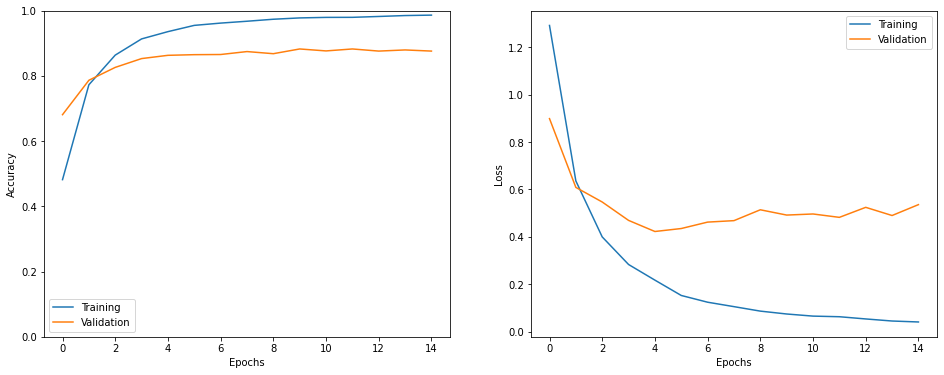

In [ ]:
# LSTM model
# Visualizing training history

show_history(history)

In [ ]:
# Prepraring a test set
new_test_tweets = [preprocess(tweet) for tweet in test_tweet]

In [ ]:
# Padding test set
# Vectorizing test set
test_padded_sequence = padded_sequences(tokenizer, test_tweet, MAX_LEN, TRUNCATING, PADDING)
test_vectorized_labels = names2ids(test_label)

In [ ]:
# Evaluating the model on test set
_ = model.evaluate(test_padded_sequence, test_vectorized_labels)

63/63 [==============================] - 1s 19ms/step - loss: 0.6620 - accuracy: 0.8530


In [ ]:
# Prediction

i = random.randint(0, len(test_label) - 1)

print('Sentence:', test_tweet[i])
print('Emotion:', test_label[i])

p = model.predict(np.expand_dims(test_padded_sequence[i], axis=0))[0]
print('Predicted Emotion:', idx2class.get(np.argmax(p)))

Sentence: i feel privileged to be a part of something so eternal and so precious to the lord jesus he shed his blood so that churches like this could exist
Emotion: joy
Predicted Emotion: joy


In [ ]:
preds = model.predict(test_padded_sequence)
preds.shape

(2000, 6)

In [ ]:
convert_preds = [np.argmax(preds[i]) for i in range(len(preds))]

In [ ]:
new_preds = [idx2class[i] for i in convert_preds]

In [ ]:
new_preds[:5]

['sadness', 'sadness', 'sadness', 'joy', 'sadness']

In [ ]:
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

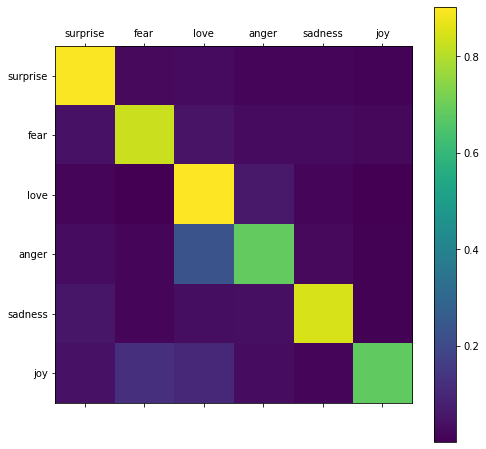

In [ ]:
show_confusion_matrix(test_label, new_preds, list(classes))